<a href="https://colab.research.google.com/github/ShivSubedi/CTscan_ImageAnalysis_LungTumorSeg/blob/main/LungtumorSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Step 1. Import the libraries
Note:
*   !pip install 'package name' specifically instructs Colab to use the pip package manager to install the specified package within the current Colab session.
*   The exclamation mark (!) before a command in a Colab cell tells Colab to execute that command as a shell command (like in a terminal).
*   If you start a new Colab session, you'll need to run the !pip install command again to install the package in the new session's environment.









In [1]:
##Please install the following libraries to execute this code/colab session
!pip install pytorch-lightning
!pip install celluloid
!pip install kaggle # install Kaggle API client
!pip install opendatasets
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00


In [2]:
%matplotlib notebook
from pathlib import Path

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from tensorboard import summary  # Or other parts of tensorboard you need
from tensorboardX import SummaryWriter
import nibabel as nib
import cv2
import os
import opendatasets as od
from itertools import islice

## Step 2. Create dataset and import data
Pros and Cons of importing data in google colab:

Cons: Colab's local disk is temporary and will be cleared whenever your session ends. This means any files or data you create or store on the local disk during a session will be lost when the session terminates.
Pros: The 15 GB storage allocated with each google account won't be occupied with data after session ends.

To preserve your work across sessions, there are two main options:
a). Google drive integration
b). Download Data Locally


### 2(A): Import dataset from Kaggle
(URL:https://www.kaggle.com/datasets/rasoulisaeid/lung-cancer-segment).
The dataset contain CT images to be used for Lung Tumor Segmentation in this notebook. Please note that these images have already been pre-processed and can be downloaded as it is.

When using non-preprocessed CT images, we need to pre-process them. The method of pre-processing has been descripted in the link above and the corresponding implementation has been shown for arbitrary test dataset in  section (6) of this notebook.

In [3]:
#downloads the dataset locally in google colab
od.download("https://www.kaggle.com/datasets/rasoulisaeid/lung-cancer-segment")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shivsubedi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rasoulisaeid/lung-cancer-segment


100%|██████████| 1.53G/1.53G [00:19<00:00, 82.4MB/s]


### 2(B): Define path to training and validation data

In [4]:
#Create datasets objects
#if Dataset defined locally, define it before this cell
#train_path and val_path contain N folders for N nifti images.
#Each of N folders contain two folders: data and masks, which contain individual slices saved as .npy files
train_path=Path("lung-cancer-segment/train/")
val_path=Path("lung-cancer-segment/val/")

### 2(C). Define augmentation
To introduce augmentation in dataset, we use Affine transformations. Affine transformations preserve the underlying geometry while introducing variations in position (e.g: 15% translation), size (e.g: scaling between 0.85 and 1.15), and orientation (e.g: rotations from -45 to 45°). Additionally, ElasticTransformation is used to simulate realistic, non-rigid deformations.
Together, these techniques enhance model robustness, generalization, and segmentation accuracy, helping the model handle diverse imaging conditions and preventing overfitting for more reliable tumor detection.


In [5]:
aff_aug = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

### 2(D). Create dataset
Implement a PyTorch Dataset with the following functionality:

a. Generate a list of all 2D slices by extracting slices from all subjects.
b. Extract the corresponding label path for each slice.
c. Load both the slice and its corresponding label.
d. Apply data augmentation, ensuring that both the slice and the label (mask) are augmented in the same way. (Hint: Consider using imgaug for augmentation.)
e. Return the augmented slice and mask.


In [6]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params=None):
        """
        Initializes the LungDataset class by extracting all the file paths
        and storing the augmentation parameters if provided.

        Args:
            root (str or Path): The root directory where the nifti files and masks are stored.
            augment_params (optional, callable): Augmentation pipeline to be applied to the images and masks.
        """
        self.all_files = self.extract_files(root)  # Get all the file paths of the slices
        self.augment_params = augment_params  # Store the augmentation parameters

    @staticmethod
    def extract_files(root):
        """
        Extracts file paths of all slices from the provided root directory.

        Args:
            root (str or Path): The root directory containing nifti images and their masks.

        Returns:
            List[Path]: A list of file paths of all slices.
        """
        files = []
        for subject in root.glob("*"):  # Iterate through each subject folder
            slice_path = subject / "data"  # Access the 'data' directory for each subject
            for slice_file in slice_path.glob("*"):  # Iterate through each slice file (.npy)
                files.append(slice_file)  # Add slice file path to the list
        return files

    @staticmethod
    def change_img_to_label_path(path):
        """
        Converts an image path to its corresponding label (mask) path by replacing
        'data' with 'masks' in the file path.

        Args:
            path (Path): The file path of the image (slice).

        Returns:
            Path: The corresponding file path of the label (mask).
        """
        parts = list(path.parts)  # Convert the path to a list of directories
        parts[parts.index("data")] = "masks"  # Replace 'data' with 'masks' to get the label path
        return Path(*parts)  # Rebuild and return the updated path

    def augment(self, slice, mask):
        """
        Applies augmentation to both the slice and its corresponding mask using the provided augmentations.

        Args:
            slice (ndarray): The 2D slice to augment.
            mask (ndarray): The corresponding mask to augment.

        Returns:
            tuple: Augmented slice and mask.
        """
        random_seed = torch.randint(0, 100000, (1, ))[0].item()  # Generate a random seed for reproducibility
        # ia.seed(random_seed)  # Set the seed for imgaug to ensure consistency during augmentation
        np.random.seed(random_seed)

        # Convert mask to SegmentationMapsOnImage for proper handling by imgaug
        mask = SegmentationMapsOnImage(mask, mask.shape)

        # Apply augmentation to both slice and mask
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)

        # Extract the augmented mask as an array
        mask_aug = mask_aug.get_arr()

        return slice_aug, mask_aug

    def __len__(self):
        """
        Returns the total number of slices in the dataset.

        Returns:
            int: The total number of slices.
        """
        return len(self.all_files)  # Return the length of the all_files list

    def __getitem__(self, idx):
        """
        Retrieves a slice and its corresponding mask, applies augmentation if provided,
        and returns the data with an added channel dimension.

        Args:
            idx (int): The index of the slice to retrieve.

        Returns:
            tuple: Augmented slice and mask with an added channel dimension.
        """
        file_path = self.all_files[idx]  # Get the slice file path
        mask_path = self.change_img_to_label_path(file_path)  # Get the corresponding mask path

        slice = np.load(file_path)  # Load the slice data
        mask = np.load(mask_path)  # Load the mask data

        # Apply augmentation if an augmentation pipeline is provided
        if self.augment_params:
            slice, mask = self.augment(slice, mask)

        # Return slice and mask with an added channel dimension (1 channel in this case)
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

### 2(E). Pass training and validation data to dataset class

In [7]:
train_dataset = LungDataset(train_path, aff_aug)
val_dataset=LungDataset(val_path, None) #don't need to augment the validation dataset

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14432 train images and 1335 val images


## Step 3: Implement Oversampling to handle strong class imbalance
Lung tumors are usually small, so we need to ensure that our model doesn’t learn a trivial solution of simply predicting zeros for all voxels. In this section, we’ll apply oversampling to increase the likelihood of selecting slices that contain tumors.

We can use PyTorch's WeightedRandomSampler for this, which requires assigning a weight to each sample. Specifically, we need to calculate two weights: one for slices without tumors and one for those with tumors, and then associate each sample in the dataset with its corresponding weight.



### 3(A). First, we create a list with only the class labels:

In [8]:
target_list = []
#_ is used as a placeholder for the loop variable because we don't need to use it in the loop
#In this case, we don’t need the actual slice (the first value returned by train_dataset)
#we use, _ as a placeholder to make it clear that we're only interested in the label (the second value)
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)  #when all pixels are 0, indicates no tumor cells
#print(target_list[1:50]) #target list contains elements 0 or 1, 1 for tumor present, 0 for tumor not present

  0%|          | 0/14432 [00:00<?, ?it/s]

### 3(B). Calculate weight of each class
To do so, we can simply compute the fraction between the classes and then create the weight list

In [9]:
#first we eliminate any duplicate entries in the target_list
# Get unique values in the target_list along with their counts
uniques = np.unique(target_list, return_counts=True)
# Display the unique values and their corresponding counts
uniques

# Extract the count of slices without tumors (first element in uniques)
tumor_NOTpresent = uniques[1][0]

# Extract the count of slices with tumors (second element in uniques)
tumor_present = uniques[1][1]

# compute the fraction
fraction = tumor_NOTpresent / tumor_present
print(f"Tumor NOT present: {tumor_NOTpresent}, Tumor present: {tumor_present}, Fraction: {fraction}")

Tumor NOT present: 12888, Tumor present: 1544, Fraction: 8.347150259067357


### 3(C). Assign weight to each class and define new 'weighted list'
we assign the weight 1 to each slice without a tumor and val(fraction) to each slice with a tumor

In [10]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)
weight_list[:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8.347150259067357,
 1,
 8.347150259067357,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8.347150259067357,
 1,
 1,
 8.347150259067357,
 1,
 8.347150259067357,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8.347150259067357,
 1,
 8.347150259067357]

### 3(D). Create a sampler
To handle the class imbalance, we create a sampler that can be passed to the DataLoader. The sampler ensures that slices with tumors are sampled more frequently during training.

Important: The sampler should only be used with the training DataLoader, as we do not want to modify the validation data in order to maintain an authentic validation set for model evaluation.

In [11]:
#sampler makes sure model sees equal amount of tumor present and absent slices during training
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

### 3(E) Creating Train and Validation DataLoaders with Custom Sampling
Define the 'train_loader' and 'val_loader' for loading the training and validation data, respectively. Set the batch size and number of workers based on your available hardware resources. For the train_loader, apply the sampler to address class imbalance during training.

In [12]:
batch_size = 32  # Number of samples processed together in a single training step
num_workers = 4  # Number of (cores) parallel subprocesses used for data loading

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#load the train_loader and print the sum for each label in the current batch (size=32)
#should observe that around 50% of all labels have sum larger than zero
#we observe that most of the batches have at least two tumorous slices, some of them even have 4
# Limit to the first 5 batches in train_loader
for data, label in islice(train_loader, 5):
    print(label.sum([1, 2, 3]))  # Compute sum along axis 1-3

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


tensor([   0,    0,    0,   15,    0,  368,  110,    3,  402,    0,  336,  802,
           0,  143,    0,  262,    0,    0,  175,    0,   62,  905,  137,    0,
           0,    9,    0,  458,    0, 1498,    0,  154])
tensor([ 433,    0,   56,   99,  145,    0,  161,  396,  626, 2122,    0,    5,
           0,    0,    0,  806,    0,    0,    0,  145,    0,    0,    0,    0,
           0,    0,  167,   28,    0,  292,    0,    0])
tensor([ 223,    0,    0,  120,    0,    0,    0,    0,   90,   99,    7,   55,
           0,   71,    0,  626,  302,   38,  586,   53,    0,   48,    0,  142,
          69,    8,    3,    0,   84,    0, 2864,   49])
tensor([389,  35,   9,   0, 152,   0,  36, 599,   0,   0,   0,   0,   0,   0,
        109, 561, 103,   0,   0,   0, 441,  84,   0,   0, 117, 383,   0,   0,
        210, 290, 116,   0])
tensor([460,   0,   0,   0,  59,  70, 377, 641,   0, 118,   0, 511,   0,  35,
        798,   0,   0, 797,   0,  61, 494,   0,   0,   0,   0,  95,   0,   0,
        

## Step 4: Define Full Segmentation Model and begin training


### 4(A). Define Convolution block
A double Convolutional Block is defined with ReLU Activation

In [13]:
class DoubleConv(torch.nn.Module):
    """
    Double convolutional block consisting of two convolutional layers followed by ReLU activations.
    This is a common building block used in convolutional neural networks for feature extraction.
    """

    def __init__(self, in_channels, out_channels):
        """
        Initializes the DoubleConv block with two convolutional layers and ReLU activations.

        Args:
        - in_channels (int): Number of input channels for the convolutional layers.
        - out_channels (int): Number of output channels after the convolutional layers.
        """
        super().__init__()  # Call the parent constructor to initialize the module

        # Define a sequential block of two convolutions each followed by a ReLU activation.
        # The kernel size is 3x3 with padding=1 to keep spatial dimensions unchanged.
        self.step = nn.Sequential(
            # First convolution layer with padding of 1
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),  # Apply ReLU activation function

            # Second convolution layer with padding of 1
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()   # Apply ReLU activation function
        )

    def forward(self, X):
        return self.step(X)

### 4(B). Define UNET
Lets build a UNet architecture with three DownConvolution and three UpConvolution layers, utilizing 64, 128, 256, and 512 filters for both the Down and UpConvolutions. Implement skip-connections between corresponding layers, and use Upsampling layers in place of transposed convolutions.

In [14]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        ############# DOWN CONVOLUTION ############
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        ############# UP CONVOLUTION ############
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256 + 128, 128)
        self.layer7 = DoubleConv(128 + 64, 64)
        self.layer8 = nn.Conv2d(64, 1, 1)  # Final 1x1 Conv layer

        self.maxpool = nn.MaxPool2d(2)  # MaxPool to reduce feature map size by 50%

    def forward(self, x):
        # Down Convolution
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)  # No MaxPool after final Down Conv layer

        # Up Convolution (using Upsample and Skip Connections)
        x5 = self._upsample_concat(x4, x3, self.layer5)
        x6 = self._upsample_concat(x5, x2, self.layer6)
        x7 = self._upsample_concat(x6, x1, self.layer7)

        # Final output layer (segmentation prediction)
        ret = self.layer8(x7)
        return ret

    def _upsample_concat(self, x, skip, layer):
        """
        Upsamples the input and concatenates it with the skip connection.
        Then passes the result through the given layer.
        mode = 'bilinear' because it is computationally efficient and produces smooth transitions
        in feature maps during upscaling, which helps in segmentation
        """
        x = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x)  # Upsample by a factor of 2, bilinear for
        x = torch.cat([x, skip], dim=1)  # Concatenate with the skip connection
        return layer(x)

### 4(C). Create a segmentation model
Lets build the PyTorch Lightning model using Binary Cross Entropy as the loss function and the Adam optimizer with a learning rate of 1e-4.

In [15]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        """
        Initialize the TumorSegmentation model.

        Args:
            model (nn.Module): The neural network model (e.g., UNet).
            loss_fn (nn.Module, optional): The loss function (defaults to BCEWithLogitsLoss).
        """
        super().__init__()
        self.model = UNet()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Model's prediction.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Training step for a single batch.

        Args:
            batch (tuple): A tuple containing input data (ct) and target labels (mask).
            batch_idx (int): Index of the current batch.

        Returns:
            Tensor: Computed loss for the batch.
        """
        ct, mask = batch
        mask = mask.float()  # Convert mask to float for loss computation
        pred = self(ct.float())  # Get model's prediction
        loss = self.loss_fn(pred, mask)  # Compute the loss
        #on_step->each batch, on_epoch->each epoch
        # self.log("Train Loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:  # Log images every 50 batches
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), 'Train')
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for a single batch.

        Args:
            batch (tuple): A tuple containing input data (ct) and target labels (mask).
            batch_idx (int): Index of the current batch.

        Returns:
            Tensor: Computed loss for the batch.
        """
        ct, mask = batch
        mask = mask.float()  # Convert mask to float for loss computation
        pred = self(ct.float())  # Get model's prediction
        loss = self.loss_fn(pred, mask)  # Compute the loss
        # self.log("Val Loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:  # Log images every 50 batches
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), 'Val')
        return loss

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
            Optimizer: The optimizer to use for training.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)  # Initialize the Adam optimizer
        return optimizer

    def log_images(self, ct, pred, mask, name):
        """Logs images of ground truth, prediction, and overlay to TensorBoard.

        Args:
            ct (tensor): Batch of CT scans (assumed shape: [batch_size, slices, height, width]).
            pred (tensor): Batch of predicted segmentation masks (assumed same shape as ct).
            mask (tensor): Batch of ground truth segmentation masks (assumed same shape as ct).
            name (str): Identifier for the logged images.
        """
        # Apply threshold (assuming sigmoid activation) for binary classification
        thresholded_pred = (pred > 0.5).float()  # Efficient thresholding with casting to float

        # Create a single figure with two subplots for ground truth and prediction
        fig, (ax_gt, ax_pred) = plt.subplots(1, 2, figsize=(10, 5))

        # Plot ground truth with CT scan as background and mask overlay
        ax_gt.imshow(ct[0, 0], cmap="bone")  # Access first slice from the batch
        ax_gt.imshow(np.ma.masked_where(mask[0, 0] == 0, mask[0, 0]), alpha=0.6)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis("off")  # Remove unnecessary axes

        # Plot prediction with CT scan as background and mask overlay (autumn colormap)
        ax_pred.imshow(ct[0, 0], cmap="bone")
        ax_pred.imshow(np.ma.masked_where(thresholded_pred[0, 0] == 0, thresholded_pred[0, 0]), alpha=0.6, cmap="autumn")
        ax_pred.set_title("Prediction")
        ax_pred.axis("off")  # Remove unnecessary axes

        # Add the combined figure to TensorBoard
        self.logger.experiment.add_figure(f"{name} - Prediction vs. Label", fig, self.global_step)

### 4(D). Instantiate the model

In [16]:
#Instantiate the model
model=TumorSegmentation()

### 4(E). Create a checkpoint callback

In [18]:
#Create the checkpoint callback
#Saving 30 checkpoints that have the lowest/min Val Dice loss
checkpoint_callback=ModelCheckpoint(
      monitor='Val Loss',
      save_top_k=30,
      mode='min')

### 4(F). Define the trainer

In [19]:
#Create the trainer
trainer = pl.Trainer(
    accelerator="auto",  # Automatically choose GPU or CPU
    devices=1,  # Use 1 GPU (if available) or CPU if GPU is not detected
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=50,  # Logging interval
    callbacks=checkpoint_callback,
    max_epochs=10 #increase the max_epocs >=30 if possible
)
print(torch.cuda.is_available())  # Should return True if a GPU is available

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


True


### 4(G). Train the model

In [20]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Training: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation: |          | 0/? [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Step 5. Evaluation of the training results

### 5(A). Load the latest checkpoint

In [21]:
# Define the checkpoint path dynamically
checkpoint_dir = Path("logs/lightning_logs/version_0/checkpoints/")
checkpoint_path = checkpoint_dir / "epoch=9-step=4510.ckpt"

# Load the model from the checkpoint
model = TumorSegmentation.load_from_checkpoint(str(checkpoint_path))

# Set the model to evaluation mode
model.eval()

# Set device based on availability of GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model.to(device)

TumorSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): 

### 5(B). Evaluate the model in validation dataset

In [22]:
# Pre-allocate lists
preds = []
labels = []

# Using no_grad context for the entire loop
with torch.no_grad():
    for slice, label in tqdm(val_dataset):
        # Convert slice to tensor, move to device, and add batch dimension
        slice_tensor = torch.tensor(slice).float().unsqueeze(0).to(device)

        # Get the prediction
        pred = torch.sigmoid(model(slice_tensor))

        # Append prediction and label to respective lists
        preds.append(pred.cpu().numpy())  # Move pred to CPU and convert to numpy
        labels.append(label)

# Convert the lists to numpy arrays
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1335 [00:00<?, ?it/s]

### 5(C). Define DiceScore and compute it
  First, define a class to compute the Dice Similarity Coefficient (Dice Score) between the prediction and the ground truth mask.
  Dice Score measures the overlap between two samples, and is widely used for image segmentation tasks.
  
  The ideal Dice score is 1.0, which indicates perfect overlap between the predicted segmentation and the ground truth (i.e., the predicted mask is exactly the same as the true mask)

In [23]:
class DiceScore(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        """
        Compute the Dice Score between predicted and true mask.

        Args:
            pred (Tensor): The predicted segmentation mask.
            mask (Tensor): The ground truth segmentation mask.

        Returns:
            float: The Dice similarity score.
        """
        # Flatten the prediction and mask tensors using `view(-1)` for more efficient memory usage
        pred = pred.view(-1)
        mask = mask.view(-1)

        # Compute intersection and union
        epsilon=1e-8
        intersection = (pred * mask).sum()  # Sum of element-wise multiplication
        union = pred.sum() + mask.sum() + epsilon  # Sum of individual tensors

        # Compute Dice score with a small epsilon to avoid division by zero
        dice_score = (2 * intersection) /union

        return dice_score

#Compute the dicescore
#Note:if DiceLoss was used as lossfunction in model, we could directly import the diceloss from the model as 'model.loss_fn'
#convert both numpy arrays of preds and labels to tensor
preds=torch.from_numpy(preds)
labels=torch.from_numpy(labels).unsqueeze(0).float()
dice_score=DiceScore()(preds,labels)
print(f"The Validation Dice Score is: {dice_score}")

The Validation Dice Score is: 0.1347188651561737


### 5(D) Evaluate Loss Curves: Training and Validation




14432
1335
{'Train Loss': tensor(0.0016), 'Val Loss': tensor(0.0014)}
The latest version path is: ./logs/lightning_logs/version_0
90
    Train epochs  Train Losses
0            0.0      0.036705
1            0.0      0.019399
2            0.0      0.015416
3            0.0      0.013999
4            0.0      0.021680
..           ...           ...
85           9.0      0.002701
86           9.0      0.002873
87           9.0      0.003520
88           9.0      0.001933
89           9.0      0.002837

[90 rows x 2 columns]
10
   Val epochs  Train Losses
0           0      0.002859
1           1      0.003520
2           2      0.001894
3           3      0.002152
4           4      0.001365
5           5      0.001379
6           6      0.001366
7           7      0.001663
8           8      0.001182
9           9      0.001384


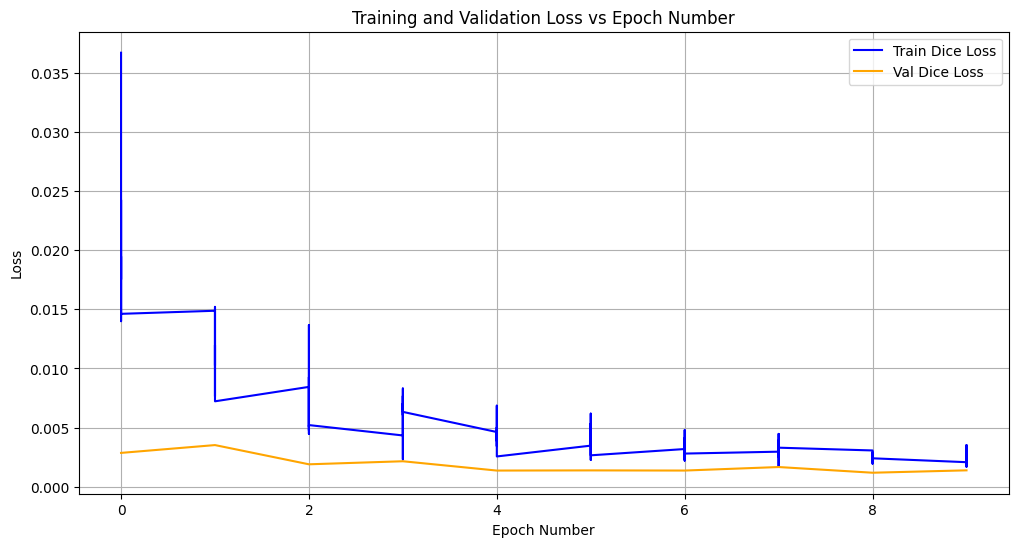

In [45]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
%matplotlib inline

print(len(train_dataset))
print(len(val_dataset))

batch_per_epoch_train=len(train_dataset)/batch_size
batch_per_epoch_val=len(val_dataset)/batch_size

print(trainer.logged_metrics)
# Path to your logs folder
log_dir = "./logs/lightning_logs"

# Find the most recent version folder
latest_version = sorted(os.listdir(log_dir))[-1]
version_path = os.path.join(log_dir, latest_version)
print(f"The latest version path is: {version_path}")


# Load the TensorBoard logs
event_acc = EventAccumulator(version_path)
event_acc.Reload()
# print(event_acc.Tags())


#---------------------------------------------------------------------------------
#Training data
#---------------------------------------------------------------------------------
#Extract Train and Val loss values
#log_every_n_steps=50, lenght_train_loss_perEpoch = batch_per_epoch_train/50.
train_loss = event_acc.Scalars('Train Loss')
print(len(train_loss))

# Get batch numbers and loss values for Train Dice
# train_batches = [entry.step for entry in train_loss] #getting Batch information
train_epochs = [entry.step // batch_per_epoch_train for entry in train_loss]
train_losses = [entry.value for entry in train_loss]

# Create a DataFrame
df_train = pd.DataFrame({'Train epochs': train_epochs, 'Train Losses': train_losses})
# Print the DataFrame
print(df_train)


#---------------------------------------------------------------------------------
#Validation data
#---------------------------------------------------------------------------------
#val loss is evaluated at end of each epoch
val_loss = event_acc.Scalars('Val Loss')
print(len(val_loss))

# Get batch numbers and loss values for Val Dice
# val_batches = [entry.step for entry in val_loss]
val_epochs = [int(entry.step / batch_per_epoch_train) for entry in val_loss]
val_losses = [entry.value for entry in val_loss]

# Create a DataFrame
df_val = pd.DataFrame({'Val epochs': val_epochs, 'Train Losses': val_losses})
# Print the DataFrame
print(df_val)


# Plot both losses
plt.figure(figsize=(12, 6))
plt.plot(train_epochs, train_losses, label="Train Dice Loss", color="blue")
plt.plot(val_epochs, val_losses, label="Val Dice Loss", color="orange")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Epoch Number")
plt.legend()
plt.grid(True)
plt.show()

## Step 6. Test the prediction on test image
Lets load a test image (not included in training and test dataset) and estimage the position of tumor

For this unfortunately the kaggle dataset downloaded above doesn't provide testdataset.
Hence, we will need to download the dataset separetely, which can be done from the following location: http://medicaldecathlon.com/

Please remember that any images that you download from above link will need to be preprocessed first before test.

In order to pre-process the CT images, please follow the steps below:

*   Normalization: Normalize CT images by dividing by 3071, as the intensity range is fixed between -1000 and 3071.
*   Cropping for Focus: Crop out the lower abdomen (e.g., skip the first 30 slices) to focus on lung tumors and reduce complexity.
*   2D Slice-Level Processing: Process the data at the slice level (2D) rather than the subject level (3D) to reduce computational cost and store the preprocessed data as 2D slices.
*   Resize Slices and Masks: Resize slices and masks to (256, 256), using cv2.INTER_NEAREST interpolation for masks to preserve label integrity.





### 6(A). Load the test image and pre-process it

In [ ]:
subject=Path("Path/to/test/image")
ct=nib.load(subject).get_fdata()/3071 #standarize
ct=ct[:,:,30:]  #crop the first 30 slices

### 6(B). Compute prediction of each slice



In [ ]:
segmentation=[]
label=[]
scan=[]
# Consider pixel values above 0.5 as part of the predicted tumor (foreground) and below 0.5 as background.
THRESHOLD=0.5

for i in range(ct.shape[-1]): #loop over the last (sagittal) axis
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256,256))
    slice = torch.tensor(slice)  # Convert slice to tensor
    scan.append(slice)  # Append slice to scan list

    # Perform tensor transformations
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)  # Add channel dim, batch dim, and move to device

    with torch.no_grad():  # Prevent pytorch from storing gradients
        pred = model(slice)[0][0].cpu()  # Apply model and remove batch and channel dims
    pred = pred > THRESHOLD # Apply threshold to the predicted segmentation mask:
    segmentation.append(pred)  # Append the prediction to segmentation list
    label.append(segmentation)  # Append the segmentation list to label


### 6(C). Visualize the slices
Loop over the slices in sagittal axis, and mask is overlayed on top of each slice. Each processed slice (with the overlayed mask) is then captured and stored using camera.snap(). Once all slices are processed, the frames are compiled into an animation using camera.animate().







In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

# Iterate over every second slice for the sagittal view
for i in range(0, len(scan), 2):
    plt.imshow(scan[i], cmap="bone")
    plt.imshow(np.ma.masked_where(segmentation[i] == 0, segmentation[i]), alpha=0.5, cmap="autumn")
    plt.axis("off")
    camera.snap()  # Store the current slice

# Generate the animation
animation = camera.animate()

### 6(D). Displaying Animation as HTML5 Video in Notebook
Convert the generated animation into a video format and display it within an IPython or Jupyter notebook environment.

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video